In [6]:
import os
import re
import numpy as np
import pandas as pd
import pickle
from typing import Literal
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import accuracy_score

# Load Data

In [2]:
data = pd.read_csv("datasets/processed/prepared_data.csv", index_col=[0])
data.head(3)

,language,domain,topic,text,category,split,processed_text,processed_lemmas
0,tr-TR,wikibooks,"geography, turkey",Türkiye'nin üç tarafı denizlerle çevrilidir: B...,6,train,türkiye'nin üç tarafı denizlerle çevrilidir ba...,türkiye üç taraf deniz çevri batı ege deniz ku...
1,tr-TR,wikibooks,"world war ii, submarines",Savaşın başlangıcında çoğunlukla denizin yüzey...,0,train,savaşın başlangıcında denizin yüzeyinde seyaha...,savaş başlangıç deniz yüzey seyahat etmek rada...
2,tr-TR,wikivoyage,"natural wonders, hill stations in india","Ancak, kış aylarında farklı bir güzelliği ve ç...",5,train,ancak kış aylarında farklı güzelliği çekiciliğ...,kış ay fark güzel çekici var birçok tepe şehir...


# utils

In [3]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaling_method: Literal["standard","minmax",None]=None):
        self.scaling_method = scaling_method
        self.scaler = None  

    def fit(self, X, y=None):
        """ Fit the appropriate scaler if required """
        if self.scaling_method is None:
            return self
        elif self.scaling_method == "standard":
            self.scaler = StandardScaler()
        elif self.scaling_method == "minmax":
            self.scaler = MinMaxScaler()
        else:
            raise ValueError(f"Unsupported scaling method: {self.scaling_method}")
        self.scaler.fit(X)
        return self 

    def transform(self, X):
        """ Transform the data if scaling is needed """
        if self.scaling_method is not None:
            return self.scaler.transform(X)
        return X  # Return original data if no scaling is required

In [55]:
def construct_sets(lang, data, col_name, target_name, vectorizer_name: Literal["CountVectorizer","TfidfVectorizer"]):
    train_ds = data[(data["language"]==lang) & (data["split"]=="train")][[col_name,target_name]]
    test_ds = data[(data["language"]==lang) & (data["split"]=="test")][[col_name,target_name]]
    val_ds = data[(data["language"]==lang) & (data["split"]=="validation")][[col_name,target_name]]

    X_train, y_train = train_ds[col_name], train_ds[target_name]
    X_test, y_test = test_ds[col_name], test_ds[target_name]
    X_val, y_val = val_ds[col_name], val_ds[target_name]

    if vectorizer_name=="CountVectorizer":
        count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,3))
        X_train = pd.DataFrame(count_vectorizer.fit_transform(X_train.values).toarray(), 
                                columns=count_vectorizer.get_feature_names_out())
        X_test = pd.DataFrame(count_vectorizer.transform(X_test.values).toarray(), 
                                columns=count_vectorizer.get_feature_names_out())
        X_val = pd.DataFrame(count_vectorizer.transform(X_val.values).toarray(), 
                                columns=count_vectorizer.get_feature_names_out())
    elif vectorizer_name=="TfidfVectorizer":
        tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
        X_train = pd.DataFrame(tfidf_vectorizer.fit_transform(X_train.values).toarray(), 
                                columns=tfidf_vectorizer.get_feature_names_out())
        X_test = pd.DataFrame(tfidf_vectorizer.transform(X_test.values).toarray(), 
                                columns=tfidf_vectorizer.get_feature_names_out())
        X_val = pd.DataFrame(tfidf_vectorizer.transform(X_val.values).toarray(), 
                                columns=tfidf_vectorizer.get_feature_names_out())
        
    return X_train,y_train,X_test,y_test,X_val,y_val 

def train_model(clf_and_params, X_train, y_train, **search_cv_params):
    clf = clf_and_params[0]
    pipeline = Pipeline([
        ("scaler", CustomScaler()),
        ("classifier", clf)
    ])

    param_grid = clf_and_params[1]
    grid_search = RandomizedSearchCV(pipeline, param_grid, **search_cv_params)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    return best_model, grid_search.best_params_

def evaluate_accuracy(y_true, y_pred):
    return round(accuracy_score(y_true, y_pred),2)*100


def get_best_pipeline(best_clf, best_params, X_train, y_train):
    scaler_params, clf_params = {}, {}
    for key, value in best_params.items():
        # param_name = key.split("__")[-1]
        if "scaler" in key:
            param_name = key.removeprefix("scaler__")
            scaler_params[param_name] = value
        else:
            param_name = key.removeprefix("classifier__")
            clf_params[param_name] = value

    best_clf.set_params(**clf_params)
    best_pipeline = Pipeline([
        ("scaler", CustomScaler(**scaler_params)),
        ("classifier", best_clf)])
    best_pipeline.fit(X_train, y_train)

    return best_pipeline

In [56]:
MODELS_and_GRID_PARAMS = {
    "MultinomialNB": (
        MultinomialNB(), 
        {"scaler__scaling_method": [None],
         "classifier__alpha": np.arange(0.1,1.1,0.1)}
    ),
    "GaussianNB": (
        GaussianNB(),
        {"scaler__scaling_method": [None]}
    ),
    "KNeighborsClassifier": (
        KNeighborsClassifier(), 
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__n_neighbors": np.arange(5,25,5)}
    ),
    "LinearSVC": (
        LinearSVC(multi_class="ovr", verbose=0, random_state=42), 
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__C": [0.1, 1, 10, 100],
         "classifier__penalty": ["l1","l2"]}
    ),
    "SVC": (
        SVC(verbose=0, random_state=42), 
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__C": [0.1, 1, 10, 100],
         "classifier__gamma": ['scale', 'auto'],
         "classifier__kernel": ['rbf', 'poly'],
         "classifier__decision_function_shape": ["ovr","ovo"],
         "classifier__probability": [True]}
    ),
    "OvR_SVC": (
        OneVsRestClassifier(SVC(kernel="linear", decision_function_shape="ovr", verbose=0, random_state=42)),
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__estimator__C": [0.1, 1, 10, 100],
         "classifier__estimator__gamma": ['scale', 'auto'],
         "classifier__estimator__kernel": ['rbf', 'poly']}
    ),
    "SGDClassifier": (
        SGDClassifier(early_stopping=True, n_iter_no_change=15, verbose=0, random_state=42),
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__max_iter": [100,1000],
         "classifier__penalty": ["l1","l2"]}
    ),
    "Perceptron": (
        Perceptron(early_stopping=True, n_iter_no_change=15, verbose=0, random_state=42),
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__max_iter": [30,100,1000],
         "classifier__penalty": ["l1","l2","elasticnet"]}
    ),
    "OvR_Logistic": (
        OneVsRestClassifier(LogisticRegression(solver='lbfgs', verbose=0, random_state=42)),
        {"scaler__scaling_method": ["standard","minmax"],
         "classifier__estimator__C": [0.1, 1, 10, 100],
         "classifier__estimator__max_iter": [50,100],
         "classifier__estimator__fit_intercept": [True, False]}
    ),
    "GradientBoostingClassifier": (
        GradientBoostingClassifier(n_iter_no_change=15, verbose=0, random_state=42),
        {"scaler__scaling_method": ["standard","minmax",None],
         "classifier__n_estimators": [5,10,25],
         "classifier__max_depth": [5,8,10],
         "classifier__learning_rate": [0.001],
         "classifier__criterion": ['friedman_mse', 'squared_error']}
    ),
    "RandomForestClassifier": (
        RandomForestClassifier(verbose=0, random_state=42),
        {"scaler__scaling_method": ["standard","minmax",None],
         "classifier__n_estimators": [10,25],
         "classifier__max_depth": [5,10],
         "classifier__criterion": ["gini","entropy"],
         "classifier__class_weight": ['balanced', 'balanced_subsample',None]}
    ),
    "XGBClassifier": (
        xgb.XGBClassifier(objective='multi:softmax', num_class=7, verbose=-1, random_state=42),
        {"scaler__scaling_method": ["standard","minmax",None],
         "classifier__n_estimators": [5,10,25],
         "classifier__max_depth": [5,8,10],
         "classifier__learning_rate": [0.001]}
    ),
    "LGBMClassifier": (
        lgb.LGBMClassifier(boosting_type='gbdt', num_class=7, verbose=-1, random_state=42),
        {"scaler__scaling_method": ["standard","minmax",None],
         "classifier__objective": ["multiclass","multiclassova"],
         "classifier__n_estimators": [5,10,25],
         "classifier__max_depth": [5,8,10],
         "classifier__learning_rate": [0.001]}
    ),
}

search_cv_params = {"n_iter": 5, "cv": StratifiedKFold(n_splits=5), "scoring": "accuracy", "n_jobs": -1}

# Building Models from BoW - texts

In [13]:
rows_tfidf = []
rows_count = []
for lang in data["language"].unique().tolist(): #["en-US"]:
    count_train,y_train,count_test,y_test,count_val,y_val = construct_sets(lang, data, col_name="processed_text", target_name="category", vectorizer_name="CountVectorizer")
    tfidf_train,y_train,tfidf_test,y_test,tfidf_val,y_val = construct_sets(lang, data, col_name="processed_text", target_name="category", vectorizer_name="TfidfVectorizer")
    
    for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
        print(f"*** {lang} - count - Modelling started for {clf_name} ***")

        best_model, best_params_ = train_model(clf_and_params, count_train, y_train, **search_cv_params)
        train_preds = best_model.predict(count_train)
        test_preds = best_model.predict(count_test)

        train_accuracy_score = evaluate_accuracy(y_train, train_preds)
        test_accuracy_score = evaluate_accuracy(y_test, test_preds)

        rows_count.append([lang,"count",clf_name,best_params_,train_accuracy_score,test_accuracy_score])
    
    for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
        print(f"*** {lang} - tfidf - Modelling started for {clf_name} ***")

        best_model, best_params_ = train_model(clf_and_params, tfidf_train, y_train, **search_cv_params)
        train_preds = best_model.predict(tfidf_train)
        test_preds = best_model.predict(tfidf_test)

        train_accuracy_score = evaluate_accuracy(y_train, train_preds)
        test_accuracy_score = evaluate_accuracy(y_test, test_preds)

        rows_tfidf.append([lang,"tfidf",clf_name,best_params_,train_accuracy_score,test_accuracy_score])

model_results_from_text = pd.DataFrame(data=rows_count+rows_tfidf, columns=["language","dataset_type","clf","best_params","train_accuracy","test_accuracy"])

*** tr-TR - count - Modelling started for MultinomialNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** tr-TR - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** tr-TR - count - Modelling started for KNeighborsClassifier ***
*** tr-TR - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** tr-TR - count - Modelling started for SVC ***
*** tr-TR - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** tr-TR - count - Modelling started for SGDClassifier ***
*** tr-TR - count - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of 

*** tr-TR - count - Modelling started for OvR_Logistic ***
*** tr-TR - count - Modelling started for GradientBoostingClassifier ***
*** tr-TR - count - Modelling started for RandomForestClassifier ***
*** tr-TR - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:48:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** tr-TR - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** tr-TR - tfidf - Modelling started for MultinomialNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** tr-TR - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** tr-TR - tfidf - Modelling started for KNeighborsClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** tr-TR - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** tr-TR - tfidf - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** tr-TR - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** tr-TR - tfidf - Modelling started for SGDClassifier ***
*** tr-TR - tfidf - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of 

*** tr-TR - tfidf - Modelling started for OvR_Logistic ***
*** tr-TR - tfidf - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** tr-TR - tfidf - Modelling started for RandomForestClassifier ***
*** tr-TR - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** tr-TR - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users

*** en-US - count - Modelling started for MultinomialNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** en-US - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** en-US - count - Modelling started for KNeighborsClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11

*** en-US - count - Modelling started for SVC ***
*** en-US - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - count - Modelling started for SGDClassifier ***
*** en-US - count - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Ma

*** en-US - count - Modelling started for OvR_Logistic ***
*** en-US - count - Modelling started for GradientBoostingClassifier ***
*** en-US - count - Modelling started for RandomForestClassifier ***
*** en-US - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** en-US - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** en-US - tfidf - Modelling started for MultinomialNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** en-US - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** en-US - tfidf - Modelling started for KNeighborsClassifier ***
*** en-US - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** en-US - tfidf - Modelling started for SVC ***
*** en-US - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - tfidf - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** en-US - tfidf - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** en-US - tfidf - Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - tfidf - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - tfidf - Modelling started for RandomForestClassifier ***
*** en-US - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:53:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:53:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:53:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:53:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** en-US - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** es-ES - count - Modelling started for MultinomialNB ***
*** es-ES - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** es-ES - count - Modelling started for KNeighborsClassifier ***
*** es-ES - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** es-ES - count - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** es-ES - count - Modelling started for OvR_SVC ***
*** es-ES - count - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** es-ES - count - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** es-ES - count - Modelling started for OvR_Logistic ***
*** es-ES - count - Modelling started for GradientBoostingClassifier ***
*** es-ES - count - Modelling started for RandomForestClassifier ***
*** es-ES - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** es-ES - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** es-ES - tfidf - Modelling started for MultinomialNB ***
*** es-ES - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** es-ES - tfidf - Modelling started for KNeighborsClassifier ***
*** es-ES - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** es-ES - tfidf - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


*** es-ES - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** es-ES - tfidf - Modelling started for SGDClassifier ***
*** es-ES - tfidf - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** es-ES - tfidf - Modelling started for OvR_Logistic ***
*** es-ES - tfidf - Modelling started for GradientBoostingClassifier ***
*** es-ES - tfidf - Modelling started for RandomForestClassifier ***
*** es-ES - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:56:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:56:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:56:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:56:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** es-ES - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:56:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Develop

*** fr-FR - count - Modelling started for MultinomialNB ***
*** fr-FR - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** fr-FR - count - Modelling started for KNeighborsClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** fr-FR - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** fr-FR - count - Modelling started for SVC ***
*** fr-FR - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** fr-FR - count - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** fr-FR - count - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** fr-FR - count - Modelling started for OvR_Logistic ***
*** fr-FR - count - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** fr-FR - count - Modelling started for RandomForestClassifier ***
*** fr-FR - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** fr-FR - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** fr-FR - tfidf - Modelling started for MultinomialNB ***
*** fr-FR - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** fr-FR - tfidf - Modelling started for KNeighborsClassifier ***
*** fr-FR - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** fr-FR - tfidf - Modelling started for SVC ***
*** fr-FR - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** fr-FR - tfidf - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** fr-FR - tfidf - Modelling started for Perceptron ***
*** fr-FR - tfidf - Modelling started for OvR_Logistic ***
*** fr-FR - tfidf - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** fr-FR - tfidf - Modelling started for RandomForestClassifier ***
*** fr-FR - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** fr-FR - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** de-DE - count - Modelling started for MultinomialNB ***
*** de-DE - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** de-DE - count - Modelling started for KNeighborsClassifier ***
*** de-DE - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** de-DE - count - Modelling started for SVC ***
*** de-DE - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** de-DE - count - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** de-DE - count - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of 

*** de-DE - count - Modelling started for OvR_Logistic ***
*** de-DE - count - Modelling started for GradientBoostingClassifier ***
*** de-DE - count - Modelling started for RandomForestClassifier ***
*** de-DE - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:01:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:01:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:01:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:01:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** de-DE - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** de-DE - tfidf - Modelling started for MultinomialNB ***
*** de-DE - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** de-DE - tfidf - Modelling started for KNeighborsClassifier ***
*** de-DE - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** de-DE - tfidf - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


*** de-DE - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** de-DE - tfidf - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** de-DE - tfidf - Modelling started for Perceptron ***
*** de-DE - tfidf - Modelling started for OvR_Logistic ***
*** de-DE - tfidf - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** de-DE - tfidf - Modelling started for RandomForestClassifier ***
*** de-DE - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:02:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:02:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:02:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:02:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** de-DE - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

In [14]:
best_inds_from_text = model_results_from_text.groupby("language")["test_accuracy"].idxmax().tolist()
bests_df_from_text = model_results_from_text.iloc[best_inds_from_text,:].sort_index()
bests_df_from_text

,language,dataset_type,clf,best_params,train_accuracy,test_accuracy
0,tr-TR,count,MultinomialNB,"{'scaler__scaling_method': None, 'classifier__...",98.0,52.0
42,fr-FR,count,LinearSVC,"{'scaler__scaling_method': 'standard', 'classi...",100.0,67.0
84,en-US,tfidf,SGDClassifier,"{'scaler__scaling_method': 'standard', 'classi...",93.0,66.0
97,es-ES,tfidf,SGDClassifier,"{'scaler__scaling_method': 'standard', 'classi...",93.0,63.0
117,de-DE,tfidf,MultinomialNB,"{'scaler__scaling_method': None, 'classifier__...",100.0,54.0


In [15]:
best_pipes_from_text = {}
for row in bests_df_from_text.iterrows():
    lang = row[1].language
    best_dataset_type = row[1].dataset_type
    if best_dataset_type=="count":
        X_train,y_train,X_test,y_test,X_val,y_val = construct_sets(lang, data, col_name="processed_text", target_name="category", vectorizer_name="CountVectorizer")
    elif best_dataset_type=="tfidf":
        X_train,y_train,X_test,y_test,X_val,y_val = construct_sets(lang, data, col_name="processed_text", target_name="category", vectorizer_name="TfidfVectorizer")

    best_params = row[1].best_params
    best_clf = MODELS_and_GRID_PARAMS[row[1].clf][0]
    
    best_pipes_from_text[lang] = get_best_pipeline(best_clf, best_params, X_train, y_train)

best_pipes_from_text

/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


{'tr-TR': Pipeline(steps=[('scaler', CustomScaler()),
                 ('classifier', MultinomialNB(alpha=np.float64(0.1)))]),
 'fr-FR': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier', LinearSVC(C=10, random_state=42))]),
 'en-US': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier',
                  SGDClassifier(early_stopping=True, n_iter_no_change=15,
                                random_state=42))]),
 'es-ES': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier',
                  SGDClassifier(early_stopping=True, n_iter_no_change=15,
                                random_state=42))]),
 'de-DE': Pipeline(steps=[('scaler', CustomScaler()),
                 ('classifier', MultinomialNB(alpha=np.float64(0.1)))])}

# Building Models from BoW - lemmas

In [16]:
rows_tfidf = []
rows_count = []
for lang in data["language"].unique().tolist(): #["en-US"]:
    count_train,y_train,count_test,y_test,count_val,y_val = construct_sets(lang, data, col_name="processed_lemmas", target_name="category", vectorizer_name="CountVectorizer")
    tfidf_train,y_train,tfidf_test,y_test,tfidf_val,y_val = construct_sets(lang, data, col_name="processed_lemmas", target_name="category", vectorizer_name="TfidfVectorizer")
    
    for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
        print(f"*** {lang} - count - Modelling started for {clf_name} ***")

        best_model, best_params_ = train_model(clf_and_params, count_train, y_train, **search_cv_params)
        train_preds = best_model.predict(count_train)
        test_preds = best_model.predict(count_test)

        train_accuracy_score = evaluate_accuracy(y_train, train_preds)
        test_accuracy_score = evaluate_accuracy(y_test, test_preds)

        rows_count.append([lang,"count",clf_name,best_params_,train_accuracy_score,test_accuracy_score])
    
    for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
        print(f"*** {lang} - tfidf - Modelling started for {clf_name} ***")

        best_model, best_params_ = train_model(clf_and_params, tfidf_train, y_train, **search_cv_params)
        train_preds = best_model.predict(tfidf_train)
        test_preds = best_model.predict(tfidf_test)

        train_accuracy_score = evaluate_accuracy(y_train, train_preds)
        test_accuracy_score = evaluate_accuracy(y_test, test_preds)

        rows_tfidf.append([lang,"tfidf",clf_name,best_params_,train_accuracy_score,test_accuracy_score])

model_results_from_lemma = pd.DataFrame(data=rows_count+rows_tfidf, columns=["language","dataset_type","clf","best_params","train_accuracy","test_accuracy"])

*** tr-TR - count - Modelling started for MultinomialNB ***
*** tr-TR - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** tr-TR - count - Modelling started for KNeighborsClassifier ***
*** tr-TR - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** tr-TR - count - Modelling started for SVC ***
*** tr-TR - count - Modelling started for OvR_SVC ***
*** tr-TR - count - Modelling started for SGDClassifier ***
*** tr-TR - count - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** tr-TR - count - Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** tr-TR - count - Modelling started for GradientBoostingClassifier ***
*** tr-TR - count - Modelling started for RandomForestClassifier ***
*** tr-TR - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:06:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:06:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:06:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:06:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** tr-TR - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** tr-TR - tfidf - Modelling started for MultinomialNB ***
*** tr-TR - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** tr-TR - tfidf - Modelling started for KNeighborsClassifier ***
*** tr-TR - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** tr-TR - tfidf - Modelling started for SVC ***
*** tr-TR - tfidf - Modelling started for OvR_SVC ***
*** tr-TR - tfidf - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** tr-TR - tfidf - Modelling started for Perceptron ***
*** tr-TR - tfidf - Modelling started for OvR_Logistic ***
*** tr-TR - tfidf - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** tr-TR - tfidf - Modelling started for RandomForestClassifier ***
*** tr-TR - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:08:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:08:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:08:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:08:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** tr-TR - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** en-US - count - Modelling started for MultinomialNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** en-US - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** en-US - count - Modelling started for KNeighborsClassifier ***
*** en-US - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


*** en-US - count - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - count - Modelling started for SGDClassifier ***
*** en-US - count - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - count - Modelling started for OvR_Logistic ***
*** en-US - count - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - count - Modelling started for RandomForestClassifier ***
*** en-US - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:09:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:09:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:09:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:09:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** en-US - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:09:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Develop

*** en-US - tfidf - Modelling started for MultinomialNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** en-US - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** en-US - tfidf - Modelling started for KNeighborsClassifier ***
*** en-US - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11

*** en-US - tfidf - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


*** en-US - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - tfidf - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** en-US - tfidf - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** en-US - tfidf - Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - tfidf - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** en-US - tfidf - Modelling started for RandomForestClassifier ***
*** en-US - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:11:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:11:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:11:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:11:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** en-US - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:11:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Develop

*** es-ES - count - Modelling started for MultinomialNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** es-ES - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** es-ES - count - Modelling started for KNeighborsClassifier ***
*** es-ES - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** es-ES - count - Modelling started for SVC ***
*** es-ES - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** es-ES - count - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** es-ES - count - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** es-ES - count - Modelling started for OvR_Logistic ***
*** es-ES - count - Modelling started for GradientBoostingClassifier ***
*** es-ES - count - Modelling started for RandomForestClassifier ***
*** es-ES - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:12:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:12:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:12:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:12:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** es-ES - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** es-ES - tfidf - Modelling started for MultinomialNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** es-ES - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** es-ES - tfidf - Modelling started for KNeighborsClassifier ***
*** es-ES - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** es-ES - tfidf - Modelling started for SVC ***
*** es-ES - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** es-ES - tfidf - Modelling started for SGDClassifier ***
*** es-ES - tfidf - Modelling started for Perceptron ***
*** es-ES - tfidf - Modelling started for OvR_Logistic ***
*** es-ES - tfidf - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** es-ES - tfidf - Modelling started for RandomForestClassifier ***
*** es-ES - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:13:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:13:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:13:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:13:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** es-ES - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:13:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Develop

*** fr-FR - count - Modelling started for MultinomialNB ***
*** fr-FR - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** fr-FR - count - Modelling started for KNeighborsClassifier ***
*** fr-FR - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** fr-FR - count - Modelling started for SVC ***
*** fr-FR - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** fr-FR - count - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** fr-FR - count - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Ma

*** fr-FR - count - Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** fr-FR - count - Modelling started for GradientBoostingClassifier ***
*** fr-FR - count - Modelling started for RandomForestClassifier ***
*** fr-FR - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:15:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:15:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:15:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:15:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** fr-FR - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:15:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Develop

*** fr-FR - tfidf - Modelling started for MultinomialNB ***
*** fr-FR - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** fr-FR - tfidf - Modelling started for KNeighborsClassifier ***
*** fr-FR - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** fr-FR - tfidf - Modelling started for SVC ***
*** fr-FR - tfidf - Modelling started for OvR_SVC ***
*** fr-FR - tfidf - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of 

*** fr-FR - tfidf - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


*** fr-FR - tfidf - Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** fr-FR - tfidf - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** fr-FR - tfidf - Modelling started for RandomForestClassifier ***
*** fr-FR - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:16:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:16:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:16:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:16:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** fr-FR - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users

*** de-DE - count - Modelling started for MultinomialNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** de-DE - count - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** de-DE - count - Modelling started for KNeighborsClassifier ***
*** de-DE - count - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** de-DE - count - Modelling started for SVC ***
*** de-DE - count - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** de-DE - count - Modelling started for SGDClassifier ***
*** de-DE - count - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Ma

*** de-DE - count - Modelling started for OvR_Logistic ***
*** de-DE - count - Modelling started for GradientBoostingClassifier ***
*** de-DE - count - Modelling started for RandomForestClassifier ***
*** de-DE - count - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:18:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:18:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:18:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:18:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** de-DE - count - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** de-DE - tfidf - Modelling started for MultinomialNB ***
*** de-DE - tfidf - Modelling started for GaussianNB ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


*** de-DE - tfidf - Modelling started for KNeighborsClassifier ***
*** de-DE - tfidf - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** de-DE - tfidf - Modelling started for SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** de-DE - tfidf - Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** de-DE - tfidf - Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** de-DE - tfidf - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** de-DE - tfidf - Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** de-DE - tfidf - Modelling started for GradientBoostingClassifier ***
*** de-DE - tfidf - Modelling started for RandomForestClassifier ***
*** de-DE - tfidf - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:20:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:20:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:20:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:20:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** de-DE - tfidf - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:20:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Develop

In [17]:
best_inds_from_lemma = model_results_from_lemma.groupby("language")["test_accuracy"].idxmax().tolist()
bests_df_from_lemma = model_results_from_lemma.iloc[best_inds_from_lemma,:].sort_index()
bests_df_from_lemma

,language,dataset_type,clf,best_params,train_accuracy,test_accuracy
3,tr-TR,count,LinearSVC,"{'scaler__scaling_method': 'standard', 'classi...",100.0,71.0
46,fr-FR,count,Perceptron,"{'scaler__scaling_method': 'standard', 'classi...",96.0,69.0
59,de-DE,count,Perceptron,"{'scaler__scaling_method': 'standard', 'classi...",96.0,56.0
81,en-US,tfidf,LinearSVC,"{'scaler__scaling_method': 'minmax', 'classifi...",100.0,69.0
94,es-ES,tfidf,LinearSVC,"{'scaler__scaling_method': 'standard', 'classi...",100.0,70.0


In [18]:
best_pipes_from_lemma = {}
for row in bests_df_from_lemma.iterrows():
    lang = row[1].language
    best_dataset_type = row[1].dataset_type
    if best_dataset_type=="count":
        X_train,y_train,X_test,y_test,X_val,y_val = construct_sets(lang, data, col_name="processed_lemmas", target_name="category", vectorizer_name="CountVectorizer")
    elif best_dataset_type=="tfidf":
        X_train,y_train,X_test,y_test,X_val,y_val = construct_sets(lang, data, col_name="processed_lemmas", target_name="category", vectorizer_name="TfidfVectorizer")

    best_params = row[1].best_params
    best_clf = MODELS_and_GRID_PARAMS[row[1].clf][0]
    
    best_pipes_from_lemma[lang] = get_best_pipeline(best_clf, best_params, X_train, y_train)

best_pipes_from_lemma

/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


{'tr-TR': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier', LinearSVC(C=100, random_state=42))]),
 'fr-FR': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier',
                  Perceptron(early_stopping=True, max_iter=30,
                             n_iter_no_change=15, penalty='l1',
                             random_state=42))]),
 'de-DE': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier',
                  Perceptron(early_stopping=True, max_iter=30,
                             n_iter_no_change=15, penalty='l1',
                             random_state=42))]),
 'en-US': Pipeline(steps=[('scaler', CustomScaler(scaling_method='minmax')),
                 ('classifier', LinearSVC(C=100, random_state=42))]),
 'es-ES': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier', LinearSVC(C=100, 

# Building Models from Embeddings

In [19]:
with open("datasets/processed/embed_and_cat.pkl", "rb") as f:
    embed_and_cat = pickle.load(f)

In [20]:
rows = []
for lang in data["language"].unique().tolist(): 
    X_train, y_train = np.array(embed_and_cat[lang]["train"]["embedding"]), np.array(embed_and_cat[lang]["train"]["category"])
    X_test, y_test = np.array(embed_and_cat[lang]["test"]["embedding"]), np.array(embed_and_cat[lang]["test"]["category"])
    X_val, y_val = np.array(embed_and_cat[lang]["validation"]["embedding"]), np.array(embed_and_cat[lang]["validation"]["category"])
    
    for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
        if clf_name not in ["MultinomialNB","GaussianNB"]: # these models do not work with negative values
            print(f"*** {lang} - Modelling started for {clf_name} ***")

            best_model, best_params_ = train_model(clf_and_params, X_train, y_train, **search_cv_params)
            train_preds = best_model.predict(X_train)
            test_preds = best_model.predict(X_test)

            train_accuracy_score = evaluate_accuracy(y_train, train_preds)
            test_accuracy_score = evaluate_accuracy(y_test, test_preds)

            rows.append([lang,clf_name,best_params_,train_accuracy_score,test_accuracy_score])

model_results_from_embedding = pd.DataFrame(data=rows, columns=["language","clf","best_params","train_accuracy","test_accuracy"])

*** tr-TR - Modelling started for KNeighborsClassifier ***
*** tr-TR - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** tr-TR - Modelling started for SVC ***
*** tr-TR - Modelling started for OvR_SVC ***
*** tr-TR - Modelling started for SGDClassifier ***
*** tr-TR - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of 

*** tr-TR - Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** tr-TR - Modelling started for GradientBoostingClassifier ***
*** tr-TR - Modelling started for RandomForestClassifier ***
*** tr-TR - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:22:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:22:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:22:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:22:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** tr-TR - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** en-US - Modelling started for KNeighborsClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** en-US - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** en-US - Modelling started for SVC ***
*** en-US - Modelling started for OvR_SVC ***
*** en-US - Modelling started for SGDClassifier ***
*** en-US - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of 

*** en-US - Modelling started for OvR_Logistic ***
*** en-US - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** en-US - Modelling started for RandomForestClassifier ***
*** en-US - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:23:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:23:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:23:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:23:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** en-US - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** es-ES - Modelling started for KNeighborsClassifier ***
*** es-ES - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** es-ES - Modelling started for SVC ***
*** es-ES - Modelling started for OvR_SVC ***
*** es-ES - Modelling started for SGDClassifier ***
*** es-ES - Modelling started for Perceptron ***
*** es-ES - Modelling started for OvR_Logistic ***
*** es-ES - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** es-ES - Modelling started for RandomForestClassifier ***
*** es-ES - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:24:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:24:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:24:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:24:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** es-ES - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** fr-FR - Modelling started for KNeighborsClassifier ***
*** fr-FR - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** fr-FR - Modelling started for SVC ***
*** fr-FR - Modelling started for OvR_SVC ***
*** fr-FR - Modelling started for SGDClassifier ***
*** fr-FR - Modelling started for Perceptron ***
*** fr-FR - Modelling started for OvR_Logistic ***
*** fr-FR - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** fr-FR - Modelling started for RandomForestClassifier ***
*** fr-FR - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:24:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:24:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:24:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:24:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** fr-FR - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

*** de-DE - Modelling started for KNeighborsClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


*** de-DE - Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** de-DE - Modelling started for SVC ***
*** de-DE - Modelling started for OvR_SVC ***
*** de-DE - Modelling started for SGDClassifier ***
*** de-DE - Modelling started for Perceptron ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of 

*** de-DE - Modelling started for OvR_Logistic ***
*** de-DE - Modelling started for GradientBoostingClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** de-DE - Modelling started for RandomForestClassifier ***
*** de-DE - Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:25:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:25:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:25:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:25:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** de-DE - Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

In [21]:
best_inds_from_embedding = model_results_from_embedding.groupby("language")["test_accuracy"].idxmax().tolist()
bests_df_from_embedding = model_results_from_embedding.iloc[best_inds_from_embedding,:].sort_index()
bests_df_from_embedding

,language,clf,best_params,train_accuracy,test_accuracy
3,tr-TR,OvR_SVC,"{'scaler__scaling_method': 'standard', 'classi...",100.0,48.0
17,en-US,OvR_Logistic,"{'scaler__scaling_method': 'minmax', 'classifi...",87.0,73.0
28,es-ES,OvR_Logistic,"{'scaler__scaling_method': 'standard', 'classi...",98.0,80.0
35,fr-FR,SVC,"{'scaler__scaling_method': 'minmax', 'classifi...",100.0,79.0
45,de-DE,LinearSVC,"{'scaler__scaling_method': 'minmax', 'classifi...",87.0,69.0


In [22]:
best_pipes_from_embeddding = {}
for row in bests_df_from_embedding.iterrows():
    lang = row[1].language

    X_train, y_train = np.array(embed_and_cat[lang]["train"]["embedding"]), np.array(embed_and_cat[lang]["train"]["category"])
    X_test, y_test = np.array(embed_and_cat[lang]["test"]["embedding"]), np.array(embed_and_cat[lang]["test"]["category"])
    X_val, y_val = np.array(embed_and_cat[lang]["validation"]["embedding"]), np.array(embed_and_cat[lang]["validation"]["category"])

    best_params = row[1].best_params
    best_clf = MODELS_and_GRID_PARAMS[row[1].clf][0]
    
    best_pipes_from_embeddding[lang] = get_best_pipeline(best_clf, best_params, X_train, y_train)

best_pipes_from_embeddding

{'tr-TR': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier',
                  OneVsRestClassifier(estimator=SVC(C=100, random_state=42,
                                                    verbose=0)))]),
 'en-US': Pipeline(steps=[('scaler', CustomScaler(scaling_method='minmax')),
                 ('classifier',
                  OneVsRestClassifier(estimator=LogisticRegression(C=0.1,
                                                                   max_iter=50,
                                                                   random_state=42)))]),
 'es-ES': Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                 ('classifier',
                  OneVsRestClassifier(estimator=LogisticRegression(C=0.1,
                                                                   max_iter=50,
                                                                   random_state=42)))]),
 'fr-FR': Pipeline(steps=[('scaler', Cu

# Building One4All Languages Model with multilingual embedding model

In [57]:
with open("datasets/processed/embed_and_cat_multilingual.pkl", "rb") as f:
    embed_and_cat_multilingual = pickle.load(f)

In [58]:
X_train, y_train, X_test, y_test, X_val, y_val  = [], [], [], [], [], []
for lang, split_dict in embed_and_cat_multilingual.items(): 
    X_train += split_dict["train"]["embedding"]
    y_train += split_dict["train"]["category"]
    X_test += split_dict["test"]["embedding"]
    y_test += split_dict["test"]["category"]
    X_val += split_dict["validation"]["embedding"]
    y_val += split_dict["validation"]["category"]
X_train, y_train, X_test, y_test, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), np.array(X_val), np.array(y_val)

rows = []
for clf_name, clf_and_params in MODELS_and_GRID_PARAMS.items():
    if clf_name not in ["MultinomialNB","GaussianNB"]: # these models do not work with negative values
        print(f"*** Modelling started for {clf_name} ***")

        best_model, best_params_ = train_model(clf_and_params, X_train, y_train, **search_cv_params)
        train_preds = best_model.predict(X_train)
        test_preds = best_model.predict(X_test)

        train_accuracy_score = evaluate_accuracy(y_train, train_preds)
        test_accuracy_score = evaluate_accuracy(y_test, test_preds)

        rows.append([clf_name,best_params_,train_accuracy_score,test_accuracy_score])

model_results_from_ml_embedding = pd.DataFrame(data=rows, columns=["clf","best_params","train_accuracy","test_accuracy"])

*** Modelling started for KNeighborsClassifier ***
*** Modelling started for LinearSVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed 

*** Modelling started for SVC ***
*** Modelling started for OvR_SVC ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** Modelling started for SGDClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


*** Modelling started for Perceptron ***
*** Modelling started for OvR_Logistic ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

*** Modelling started for GradientBoostingClassifier ***
*** Modelling started for RandomForestClassifier ***
*** Modelling started for XGBClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:32:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:32:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:32:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:32:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:74

*** Modelling started for LGBMClassifier ***


/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/toygunkarabas/Development/NLP & SLP/nlp_slp_env/lib/pytho

In [59]:
model_results_from_ml_embedding

,clf,best_params,train_accuracy,test_accuracy
0,KNeighborsClassifier,"{'scaler__scaling_method': 'minmax', 'classifi...",100.0,81.0
1,LinearSVC,"{'scaler__scaling_method': 'minmax', 'classifi...",100.0,81.0
2,SVC,"{'scaler__scaling_method': 'standard', 'classi...",100.0,63.0
3,OvR_SVC,"{'scaler__scaling_method': 'standard', 'classi...",100.0,81.0
4,SGDClassifier,"{'scaler__scaling_method': 'standard', 'classi...",99.0,85.0
5,Perceptron,"{'scaler__scaling_method': 'standard', 'classi...",100.0,82.0
6,OvR_Logistic,"{'scaler__scaling_method': 'minmax', 'classifi...",100.0,82.0
7,GradientBoostingClassifier,"{'scaler__scaling_method': None, 'classifier__...",43.0,34.0
8,RandomForestClassifier,"{'scaler__scaling_method': 'standard', 'classi...",100.0,66.0
9,XGBClassifier,"{'scaler__scaling_method': 'minmax', 'classifi...",94.0,45.0


In [60]:
best_inds_from_ml_embedding = model_results_from_ml_embedding["test_accuracy"].idxmax()
clf = model_results_from_ml_embedding.loc[best_inds_from_ml_embedding,"clf"]
best_params = model_results_from_ml_embedding.loc[best_inds_from_ml_embedding,"best_params"]
best_clf = MODELS_and_GRID_PARAMS[clf][0]

clf, best_params

('SGDClassifier',
 {'scaler__scaling_method': 'standard',
  'classifier__penalty': 'l2',
  'classifier__max_iter': 1000})

In [61]:
X_train, y_train, X_test, y_test, X_val, y_val  = [], [], [], [], [], []
for lang, split_dict in embed_and_cat_multilingual.items(): 
    X_train += split_dict["train"]["embedding"]
    y_train += split_dict["train"]["category"]
    X_test += split_dict["test"]["embedding"]
    y_test += split_dict["test"]["category"]
    X_val += split_dict["validation"]["embedding"]
    y_val += split_dict["validation"]["category"]
X_train, y_train, X_test, y_test, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), np.array(X_val), np.array(y_val)

best_pipe_from_ml_embeddding = get_best_pipeline(best_clf, best_params, X_train, y_train)
best_pipe_from_ml_embeddding

Pipeline(steps=[('scaler', CustomScaler(scaling_method='standard')),
                ('classifier',
                 SGDClassifier(early_stopping=True, n_iter_no_change=15,
                               random_state=42))])

In [62]:
rows = []
for lang, split_dict in embed_and_cat_multilingual.items(): 
    X_train = split_dict["train"]["embedding"]
    y_train = split_dict["train"]["category"]
    X_test = split_dict["test"]["embedding"]
    y_test = split_dict["test"]["category"]
    X_val = split_dict["validation"]["embedding"]
    y_val = split_dict["validation"]["category"]
    X_train, y_train, X_test, y_test, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), np.array(X_val), np.array(y_val)

    train_preds = best_pipe_from_ml_embeddding.predict(X_train)
    test_preds = best_pipe_from_ml_embeddding.predict(X_test)
    val_preds = best_pipe_from_ml_embeddding.predict(X_val)

    train_accuracy_score = evaluate_accuracy(y_train, train_preds)
    test_accuracy_score = evaluate_accuracy(y_test, test_preds)
    val_accuracy_score = evaluate_accuracy(y_val, val_preds)

    rows.append([lang,train_accuracy_score,test_accuracy_score,val_accuracy_score]) 

best_pipe_perf_by_lang = pd.DataFrame(data=rows, columns=["lang","train_accuracy","test_accuracy","val_accuracy"])

In [63]:
best_pipe_perf_by_lang

,lang,train_accuracy,test_accuracy,val_accuracy
0,tr-TR,99.0,88.0,90.0
1,en-US,100.0,83.0,85.0
2,es-ES,99.0,85.0,90.0
3,fr-FR,99.0,82.0,86.0
4,de-DE,99.0,85.0,84.0


# Observations

Bow modelling approach and using spacy embeddings do not provide much information for the model to predict categories. Thus models are lack of generalization considering train accuracies and also difference between train and test accuracies. However, using multilingual embedding with One4All modelling is much better option for each language. However, train accuracies are 99-100% percent which indicates overfitting as well. Reducing dimensions from 1024 to 300-500 maybe overcome overfitting or for some algorithms such as xgboost we can use early stoppings.

In [ ]:
bests_df_from_text

,language,dataset_type,clf,best_params,train_accuracy,test_accuracy
0,tr-TR,count,MultinomialNB,"{'scaler__scaling_method': None, 'classifier__...",98.0,52.0
42,fr-FR,count,LinearSVC,"{'scaler__scaling_method': 'standard', 'classi...",100.0,67.0
84,en-US,tfidf,SGDClassifier,"{'scaler__scaling_method': 'standard', 'classi...",93.0,66.0
97,es-ES,tfidf,SGDClassifier,"{'scaler__scaling_method': 'standard', 'classi...",93.0,63.0
117,de-DE,tfidf,MultinomialNB,"{'scaler__scaling_method': None, 'classifier__...",100.0,54.0


In [34]:
bests_df_from_lemma

,language,dataset_type,clf,best_params,train_accuracy,test_accuracy
3,tr-TR,count,LinearSVC,"{'scaler__scaling_method': 'standard', 'classi...",100.0,71.0
46,fr-FR,count,Perceptron,"{'scaler__scaling_method': 'standard', 'classi...",96.0,69.0
59,de-DE,count,Perceptron,"{'scaler__scaling_method': 'standard', 'classi...",96.0,56.0
81,en-US,tfidf,LinearSVC,"{'scaler__scaling_method': 'minmax', 'classifi...",100.0,69.0
94,es-ES,tfidf,LinearSVC,"{'scaler__scaling_method': 'standard', 'classi...",100.0,70.0


In [32]:
bests_df_from_embedding

,language,clf,best_params,train_accuracy,test_accuracy
3,tr-TR,OvR_SVC,"{'scaler__scaling_method': 'standard', 'classi...",100.0,48.0
17,en-US,OvR_Logistic,"{'scaler__scaling_method': 'minmax', 'classifi...",87.0,73.0
28,es-ES,OvR_Logistic,"{'scaler__scaling_method': 'standard', 'classi...",98.0,80.0
35,fr-FR,SVC,"{'scaler__scaling_method': 'minmax', 'classifi...",100.0,79.0
45,de-DE,LinearSVC,"{'scaler__scaling_method': 'minmax', 'classifi...",87.0,69.0


In [64]:
best_pipe_perf_by_lang

,lang,train_accuracy,test_accuracy,val_accuracy
0,tr-TR,99.0,88.0,90.0
1,en-US,100.0,83.0,85.0
2,es-ES,99.0,85.0,90.0
3,fr-FR,99.0,82.0,86.0
4,de-DE,99.0,85.0,84.0


## Detailed Analysis of best pipeline

In [85]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

In [67]:
category_map = {
    0: "science/technology",
    1: "travel",
    2: "politics",
    3: "sports",
    4: "health",
    5: "entertainment",
    6: "geography"
}

In [68]:
X_train, y_train, X_test, y_test, X_val, y_val  = [], [], [], [], [], []
for lang, split_dict in embed_and_cat_multilingual.items(): 
    X_train += split_dict["train"]["embedding"]
    y_train += split_dict["train"]["category"]
    X_test += split_dict["test"]["embedding"]
    y_test += split_dict["test"]["category"]
    X_val += split_dict["validation"]["embedding"]
    y_val += split_dict["validation"]["category"]
X_train, y_train, X_test, y_test, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), np.array(X_val), np.array(y_val)

y_test_pred = best_pipe_from_ml_embeddding.predict(X_test)

In [73]:
print(classification_report(y_test, y_test_pred, target_names=category_map.values()))

                    precision    recall  f1-score   support

science/technology       0.88      0.88      0.88       257
            travel       0.75      0.80      0.77       133
          politics       0.92      0.97      0.94       139
            sports       0.93      0.90      0.92        90
            health       0.82      0.89      0.86        76
     entertainment       0.88      0.61      0.72        75
         geography       0.71      0.72      0.72        87

          accuracy                           0.85       857
         macro avg       0.84      0.83      0.83       857
      weighted avg       0.85      0.85      0.85       857



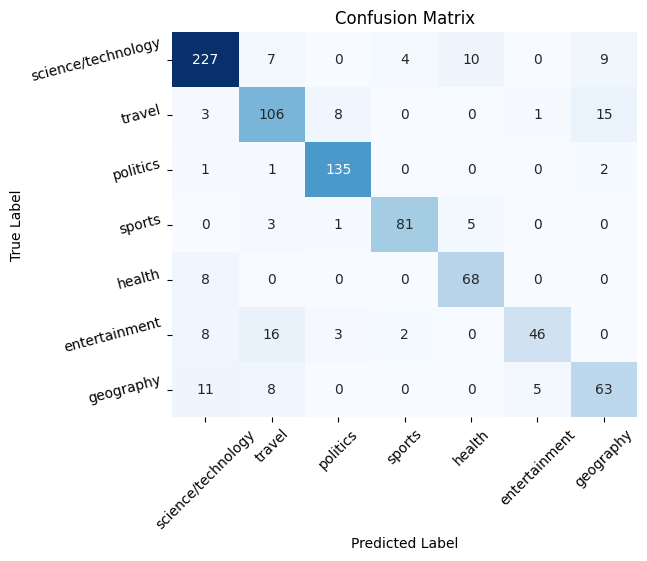

In [82]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=category_map.values(), yticklabels=category_map.values())
plt.xticks(rotation=45)
plt.yticks(rotation=15)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Get class probability scores
y_test_prob = best_pipe_from_ml_embeddding.predict_proba(X_test)

# Get ROC metrics and plot
fpr = {}
tpr = {}
thresh ={}
roc_auc = {}
colors = ['orange','green','blue','yellow','black','purple','red']
for i in range(len(np.unique(y_train))):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_test_prob[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], linestyle='--', color=colors[i], label=f'Class {category_map[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

# Compute the macro-average AUC score
macro_auc = roc_auc_score(label_binarize(y_test, classes=category_map.values()), y_test_prob, average="macro")
print(f"Macro-Averaged AUC: {macro_auc:.2f}")

# Improvement Areas:

- Hyperparameter tuning can be done with larger parameter grids and for greater number of iterations in randomized search.
- GridSearchCV, Optuna can be used in hyperparameter tuning.
- Dimension of embedding models can be increased to get better performance. (i.e. trying larger spacy models or different embedding models in HuggingFace etc.)

# Resources

https://scikit-learn.org/stable/modules/multiclass.html

https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier

https://www.kaggle.com/code/satishgunjal/binary-multiclass-classification-using-sklearn

https://www.kaggle.com/code/emmanuelfwerr/xgboost-multi-class-classification

https://www.kaggle.com/code/syerramilli/ps4e03-multi-class-lightgbm